### Choose image for segmentation

In [ ]:
import sys
sys.path.insert(0, "../")

import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


In [ ]:
import os
from IPython.display import display
from ipywidgets import Dropdown, Output
from IPython.display import display, clear_output
from appraiser.extractors import read_image, embeddings_vec

test_images_folder = 'C:\\research\\data\\images_to_segmentation'
images_list = os.listdir(test_images_folder)

output = Output()
dropdown = Dropdown(description="Choose image:", options=images_list)



def dropdown_eventhandler(change):
    with output:
        clear_output()
        image_path = os.path.join(test_images_folder,change.new)
        image = read_image(image_path)
        aspect_ratio = image.size[0] / image.size[1]
        max_height = 250
        resized_width = int(max_height * aspect_ratio)
        resized_img = image.resize((resized_width, max_height))
        display(resized_img)


dropdown.observe(dropdown_eventhandler, names='value')
display(dropdown, output)

In [29]:
image_path = os.path.join(test_images_folder,dropdown.value)
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

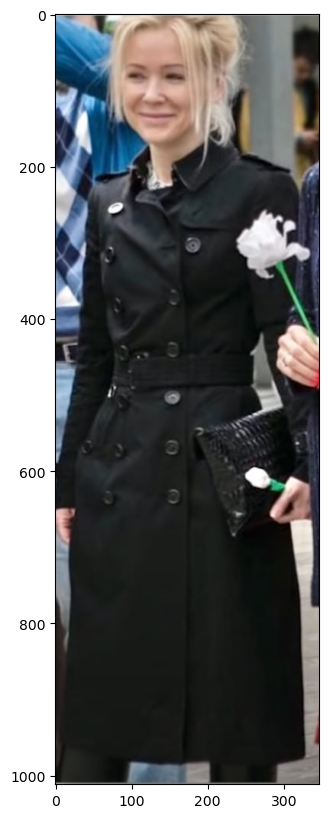

In [30]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

### Intialize SAM model

In [ ]:
!pip3 install git+https://github.com/facebookresearch/segment-anything.git

In [ ]:
!pip3 install opencv-python pycocotools matplotlib onnxruntime onnx

In [ ]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [31]:
import sys
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "C:\\research\\models\\sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)
predictor.set_image(image)

In [32]:
# Choose point to mask
input_points = np.array([[200, 915]])
input_labels = np.array([1])
# input_points = np.array([[200, 915], [220, 915],[200, 615],[190, 715],[150, 515],[160, 315]])
# input_labels = np.array([1, 1, 1, 1,1,1])

In [33]:
masks, scores, logits = predictor.predict(
    point_coords=input_points,
    point_labels=input_labels,
    multimask_output=True,
)

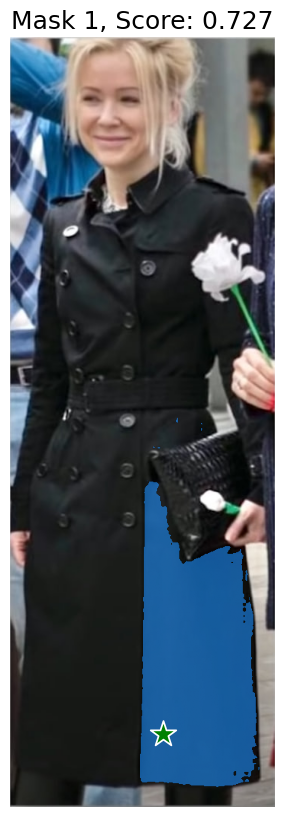

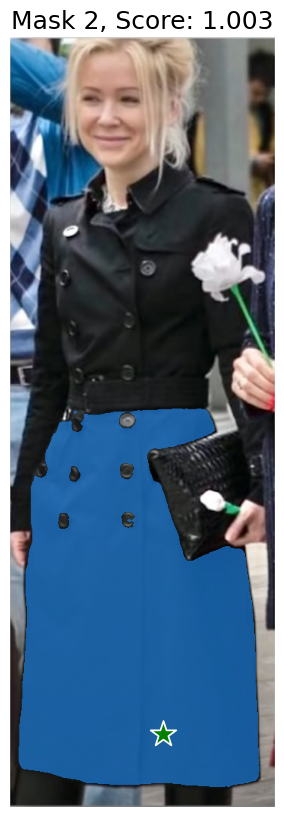

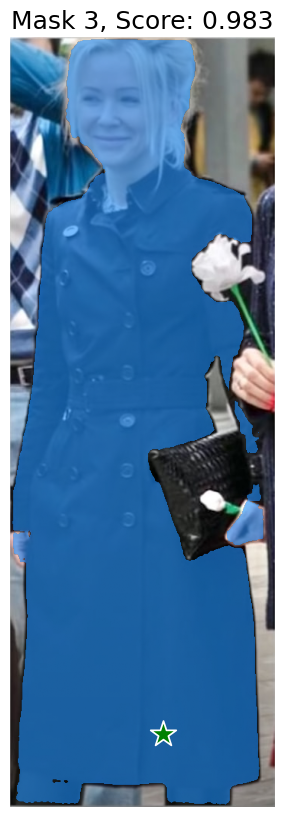

In [34]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_points, input_labels, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()


In [ ]:
# Remove background by turn it to white
image[masks[1]==False] = [255,255,255]

plt.imshow(image)
plt.axis('off')

In [39]:
# Save image
cv2.imwrite('C:\\research\\data\\test_images\\miz_trench_cutout.jpg', image)

True